# Remaining Useful Life Prediction of Turbofan Engines

In [1]:
# Enable autoreloading
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from pmlib.data_transformation import split_data
from pmlib.preprocessing import create_series_id
from pmlib.modeling import smooth_predictions
from sklearn.preprocessing import RobustScaler

%matplotlib inline
# mpl.style.use('ggplot')

In [2]:
N_JOBS = 32
RANDOM_STATE = 7

In [4]:
!mkdir -p ./data/turbofan_engine_degradation/
!mkdir -p ./images/turbofan_engine_degradation/

## Load and Preprocess Data

In [3]:
!wget -nc https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip ./data/turbofan_engine_degradation/
!unzip -o ./data/turbofan_engine_degradation/CMAPSSData.zip -d ./data/turbofan_engine_degradation/

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/root/.wget-hsts'. HSTS will be disabled.
--2020-05-28 20:17:07--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘CMAPSSData.zip’

CMAPSSData.zip      100%[===================>]  11.85M  4.55MB/s    in 2.6s    

2020-05-28 20:17:10 (4.55 MB/s) - ‘CMAPSSData.zip’ saved [12425978/12425978]

--2020-05-28 20:17:10--  http://./data/turbofan_engine_degradation/
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-05-28 20:17:10--
Total wall clock time: 3.7s
Downloaded: 1 files, 12M in 2.6s (4.55 MB/s)


In [3]:
RAW_DATA_PATH = Path('./data/turbofan_engine_degradation/train_FD001.txt')

In [4]:
sensor_cols = [f'sensor_{i}' for i in range(1, 27)]
operational_setting_cols = [f'operational_setting_{i}' for i in range(1, 4)]
feature_cols = [*operational_setting_cols, *sensor_cols]
columns = ['unit number', 'cycles', *feature_cols]

data = pd.read_csv(RAW_DATA_PATH, sep=' ', header=None, names=columns)

data.dropna(axis=1, inplace=True)

sensor_cols = data.columns[data.columns.str.startswith('sensor_')]
operational_setting_cols = data.columns[data.columns.str.startswith('operational_setting_')]
feature_cols = [*operational_setting_cols, *sensor_cols]
columns = ['unit number', 'cycles', *feature_cols]

def f(df):
    df[feature_cols] = df[feature_cols].rolling(11, min_periods=1).mean()
    return df

data = data.groupby('unit number').apply(f)

# Drop columns with zero variance
data = data.drop(columns=data.columns[data.var() == 0])
sensor_cols = data.columns[data.columns.str.startswith('sensor_')]
operational_setting_cols = data.columns[data.columns.str.startswith('operational_setting_')]

feature_cols = [*operational_setting_cols, *sensor_cols, 'cycles']

data['RUL'] = (1 + data.iloc[::-1].groupby('unit number').cumcount().iloc[::-1])

In [5]:
subject_id_col = 'unit number'

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit number            20631 non-null  int64  
 1   cycles                 20631 non-null  int64  
 2   operational_setting_1  20631 non-null  float64
 3   operational_setting_2  20631 non-null  float64
 4   sensor_1               20631 non-null  float64
 5   sensor_2               20631 non-null  float64
 6   sensor_3               20631 non-null  float64
 7   sensor_4               20631 non-null  float64
 8   sensor_5               20631 non-null  float64
 9   sensor_6               20631 non-null  float64
 10  sensor_7               20631 non-null  float64
 11  sensor_8               20631 non-null  float64
 12  sensor_9               20631 non-null  float64
 13  sensor_10              20631 non-null  float64
 14  sensor_11              20631 non-null  float64
 15  se

In [7]:
data.apply(np.round, decimals=2)

,unit number,cycles,operational_setting_1,operational_setting_2,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,...,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0,-0.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,47.47,521.66,2388.02,8138.62,8.42,0.03,392.00,39.06,23.42,192
1,1,2,0.0,-0.0,518.67,641.98,1590.76,1401.87,14.62,21.61,...,47.48,521.97,2388.04,8135.06,8.43,0.03,392.00,39.03,23.42,191
2,1,3,-0.0,-0.0,518.67,642.11,1589.84,1402.65,14.62,21.61,...,47.41,522.12,2388.04,8134.45,8.42,0.03,391.33,39.00,23.40,190
3,1,4,-0.0,-0.0,518.67,642.17,1588.08,1402.45,14.62,21.61,...,47.34,522.31,2388.05,8134.29,8.41,0.03,391.50,38.97,23.39,189
4,1,5,-0.0,-0.0,518.67,642.21,1587.03,1403.21,14.62,21.61,...,47.33,522.28,2388.05,8134.19,8.41,0.03,391.80,38.96,23.39,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.0,0.0,518.67,643.47,1599.07,1426.01,14.62,21.61,...,48.11,519.91,2388.24,8140.89,8.51,0.03,395.82,38.46,23.09,5
20627,100,197,-0.0,-0.0,518.67,643.46,1600.07,1426.76,14.62,21.61,...,48.11,519.83,2388.24,8140.75,8.51,0.03,395.91,38.44,23.10,4
20628,100,198,-0.0,-0.0,518.67,643.44,1600.57,1427.37,14.62,21.61,...,48.11,519.81,2388.24,8140.80,8.52,0.03,396.09,38.42,23.07,3
20629,100,199,-0.0,0.0,518.67,643.45,1601.25,1427.37,14.62,21.61,...,48.12,519.78,2388.24,8140.74,8.52,0.03,396.09,38.41,23.07,2


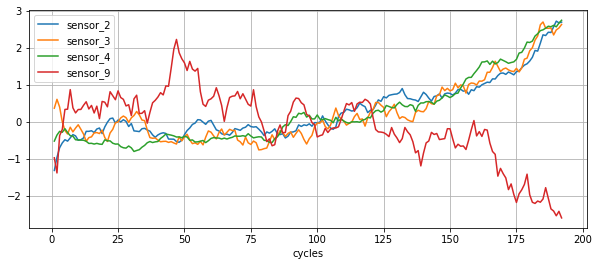

In [8]:
df = data.loc[lambda df: df['unit number'].eq(1), sensor_cols]
df.index += 1
df[df.columns] = RobustScaler().fit_transform(df)

df[df.columns[[1, 2, 3, 8]]].plot(figsize=(10, 4))
plt.grid()
plt.xlabel('cycles')
plt.savefig('./images/turbofan_engine_degradation/experiments_rul_sensor_values.pdf', bbox_inches='tight')

## Data Splitting

In [9]:
from pmlib.data_transformation import split_data
from pmlib.utils import print_data_info
from sklearn.model_selection import train_test_split


def split_turbofan_data(df):
    X, y, groups = split_data(df=df,
                              feature_cols=feature_cols,
                              target_col='RUL',
                              series_id_col='unit number',
                              subject_id_col='unit number',
                             )
    return X, y, groups



subjects_train, subjects_test = train_test_split(data[subject_id_col].unique(), shuffle=True, test_size=0.2, random_state=1)

data_train = data.loc[data[subject_id_col].isin(subjects_train)]
data_test = data.loc[data[subject_id_col].isin(subjects_test)]

X_train, y_train, groups_train = split_turbofan_data(data_train)
X_test, y_test, groups_test = split_turbofan_data(data_test)

print('Training set:')
print_data_info(X_train, y_train, groups_train)
print('Testing set:')
print_data_info(X_test, y_test, groups_test)

Training set:
	# of subjects: 80
	# of series: 80
	# of samples: 16663
Testing set:
	# of subjects: 20
	# of series: 20
	# of samples: 3968


## Candidate Models Selection

In [10]:
warning_time = 5

In [11]:
from itertools import product
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

tested_models = [
    *[
        XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, n_jobs=1, random_state=5)
        for max_depth, n_estimators in product([3, 4, 5, 7, 8, 9], [16, 32, 64, 128, 256])
    ],
    *[
        SVR(kernel='rbf', C=C, gamma=gamma)
        for gamma, C in product([0.01, 0.1, 0.5, 1], [0.1, 1, 10, 100])
    ],
]

tested_models = [Pipeline([
    ('scaler', RobustScaler(quantile_range=(5, 90))),
    ('estimator', estimator)
]) for estimator in tested_models]

param_distributions = {
    'estimator': tested_models,
}

### Define Evaluation Metrics

In [12]:
from pmlib.evaluation.rul import (mean_prognostic_horizon,
                                  mean_absolute_percentage_error,
                                  mean_asymmetrically_weighted_percentage_error)
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_squared_log_error)
from sklearn.metrics import make_scorer
from pmlib.evaluation.utils import series_scorer

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorers = {
    "rmse": make_scorer(
        score_func=series_scorer(
            root_mean_squared_error,
            warning_time=warning_time
        ),
        greater_is_better=False
    ),
    "mape": make_scorer(
        score_func=series_scorer(
            mean_absolute_percentage_error,
            warning_time=warning_time
        ),
        greater_is_better=False
    ),
    'mape@40': make_scorer(
        score_func=series_scorer(
            score_func=mean_absolute_percentage_error,
            artificial_window=1,
            warning_time=warning_time,
            evaluation_window=40
        ),
        greater_is_better=False
    ),
    'mph_10': make_scorer(
        score_func=mean_prognostic_horizon,
        alpha=10
    ),
}

### CV Search

In [13]:
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from pmlib.modeling import PredictiveMaintenanceModel

search_pipeline = RandomizedSearchCV(
    estimator=PredictiveMaintenanceModel(),
    param_distributions=param_distributions,
    scoring=scorers,
    cv=GroupKFold(n_splits=10),
    refit=False,
    verbose=10,
    n_jobs=N_JOBS,
    n_iter=100,
    random_state=5,
)

training_series_limit = int(1e10)
# training_series_limit = 30
search_pipeline.fit(X_train[:training_series_limit],
                    y_train[:training_series_limit],
                    groups_train[:training_series_limit])

cv_results = pd.DataFrame(search_pipeline.cv_results_)

Fitting 10 folds for each of 46 candidates, totalling 460 fits


/root/.cache/pypoetry/virtualenvs/pmlib-O0UWtbZz-py3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 46 is smaller than n_iter=100. Running 46 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:    6.7s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:    9.1s
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:   11.6s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:   12.4s
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:   15.9s
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   19.6s
[Parallel(n_jobs=32)]: Done 157 tasks      | ela

### Correlation Analysis of Evaluation Metrics

In [14]:
scorer_columns = [f'mean_test_{scorer_name}' for scorer_name in scorers.keys()]
scorer_rank_columns = [f'rank_test_{scorer_name}' for scorer_name in scorers.keys()]
param_cols = cv_results.columns[cv_results.columns.str.startswith('param_')]

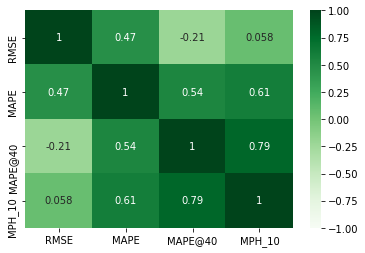

In [15]:
import seaborn as sns

df = cv_results.copy()

renaming = {s: f'{s.upper()[10:]}' for s in scorer_rank_columns}
df = df[scorer_rank_columns].rename(columns=renaming).corr()
sns.heatmap(df, annot=True, cmap='Greens', vmin=-1, vmax=1)
plt.savefig('./images/turbofan_engine_degradation/experiments_rul_heatmap.pdf', bbox_inches='tight')

<Figure size 216x216 with 0 Axes>

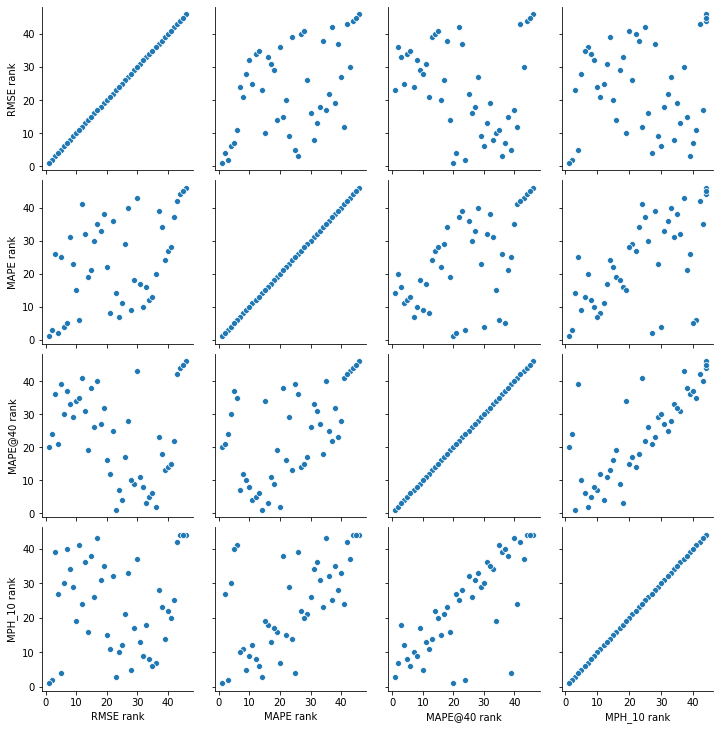

In [30]:
cols = [f'rank_test_{col}' for col in ['rmse', 'mape', 'mape@40', 'mph_10']]

renaming = {s: f'{s.upper()[10:]} rank' for s in cols}

df = cv_results.rename(columns=renaming).copy()
df['param_estimator'] = df['param_estimator'].apply(lambda x: type(x[-1]).__name__)
rank_cols = list(renaming.values())
plt.figure(figsize=(3, 3))
sns.pairplot(df, x_vars=rank_cols, y_vars=rank_cols,
#              hue='param_estimator',
             diag_kind=None)
plt.savefig('./images/turbofan_engine_degradation/experiments_rul_pairplot.pdf', bbox_inches='tight')

In [17]:
import string


def extract_params(x):
    model = x[-1]
    all_params = model.get_params()
    params = dict()
    if type(model) == XGBRegressor:
        params = {k:all_params[k] for k in ('n_estimators', 'max_depth')}
    elif type(model) == SVR:
        params = {k:all_params[k] for k in ('C', 'gamma')}
    return params


df = (
    cv_results
    .copy()
    .loc[lambda df:
             df[scorer_rank_columns].min(axis=1).eq(1)
         ,[*scorer_rank_columns, *param_cols, *scorer_columns]]
    .reset_index(drop=True)
    .drop_duplicates(subset=scorer_rank_columns)
)
df[scorer_columns] =  df[scorer_columns].astype(float).abs().round(1)
df = df.rename(columns={s: f'rank by {s.upper()[10:]}' for s in scorer_rank_columns})
df = df.rename(columns={s: f'{s.upper()[10:]}' for s in scorer_columns})
df['params'] = df['param_estimator'].apply(extract_params)
df = df.T
df.loc['regressor'] = df.loc['param_estimator']
df.loc['regressor'] = df.loc['regressor'].apply(lambda x: type(x[-1]).__name__)
# df.drop(labels=['param_estimator']).to_latex('candidate_models.tex')
display(df.drop(labels=['param_estimator']))

selected_models_parameters = df

,0,1
rank by RMSE,23,1
rank by MAPE,14,1
rank by MAPE@40,1,20
rank by MPH_10,3,1
RMSE,42.9,37.6
MAPE,30.3,27.5
MAPE@40,38.4,42.3
MPH_10,29.8,32.8
params,"{'n_estimators': 16, 'max_depth': 7}","{'C': 100, 'gamma': 0.1}"
regressor,XGBRegressor,SVR


In [18]:
df.loc['param_estimator'].values[0]

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(5, 90),
                              with_centering=True, with_scaling=True)),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, gamma=None, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=7,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=16,
                              n_jobs=1, num_parallel_tree=None,
                              objective='reg:squarederror', random_state=5,
                              reg_alpha=None, reg_lambda=None,
                           

In [19]:
from tqdm import tqdm


def train_selected_pdm_model(estimator):
    pdm_model = PredictiveMaintenanceModel(estimator=estimator)
    try:
        pdm_model.estimator.set_params(n_jobs=N_JOBS)
    except Exception:
        pass
    try:
        pdm_model.estimator.set_params(random_state=RANDOM_STATE)
    except Exception:
        pass
    pdm_model.fit(X_train, y_train)
    return pdm_model


selected_models = [train_selected_pdm_model(model) for model in tqdm(df.loc['param_estimator'].values)]

100%|██████████| 2/2 [00:34<00:00, 17.22s/it]


## Candidate Models Comparison

In [25]:
candidate_models_predictions = [model.predict(X_test) for model in tqdm(selected_models)]
candidate_models_predictions = np.array(list(zip(['XGBoost', 'SVR'], np.array(candidate_models_predictions))))

100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


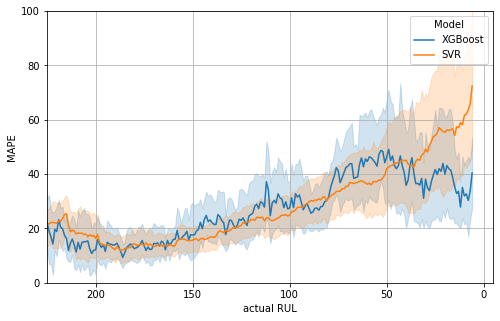

In [22]:
def relative_mape(y, y_pred):
    return np.abs((y - y_pred) / y) * 100

fig, ax = plt.subplots(figsize=(8, 5))
for model_id, y_pred in candidate_models_predictions:
    df = pd.DataFrame({'RUL': np.hstack(y_test),
                       'MAPE': relative_mape(np.hstack(y_test), np.hstack(y_pred))})

    df = (
        df
        .loc[df['RUL'].gt(warning_time)
            ]
        .reset_index()
    )
    sns.lineplot(data=df, x='RUL', y='MAPE', label=model_id)
plt.xlim(225, -5)
plt.ylim(0, 100)
plt.legend(title='Model')
plt.xlabel('actual RUL')
plt.ylabel('MAPE')
plt.grid()
# plt.axvline(warning_time, color='black')
plt.savefig('./images/turbofan_engine_degradation/experiments_rul_relative_mape.pdf', bbox_inches='tight')

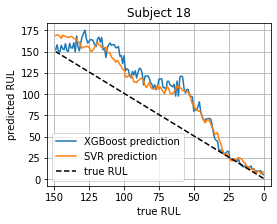

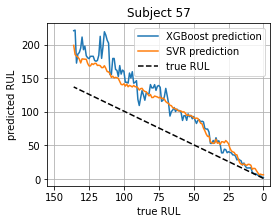

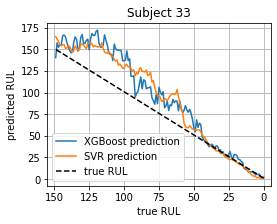

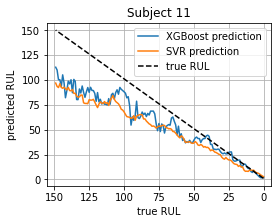

In [26]:
rul_lim = 150

for i in [5, 12, 15, 19]:
    subject_id = subjects_test[i]
    plt.figure(figsize=(4, 3))
    for model_id, y_pred_series in candidate_models_predictions:
        preds = y_pred_series[i][-rul_lim:][::-1]
        plt.plot(preds, label=f'{model_id} prediction')
    plt.plot(y_test[i][-rul_lim:][::-1], color='black', linestyle='--', label='true RUL')
    plt.grid()
    plt.xlabel('true RUL')
    plt.ylabel('predicted RUL')
    plt.xlim(155, -5)
    plt.legend()
    plt.title(f'Subject {subject_id}')
    plt.savefig(f'./images/turbofan_engine_degradation/experiments_rul_prediction_{subject_id}.pdf', bbox_inches='tight')
    plt.show()

## Miscellaneous

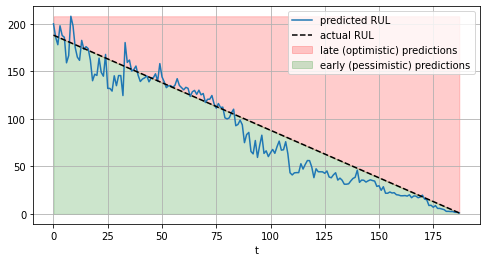

In [24]:
rul_lim = 250

i = 6
subject_id = subjects_test[i]
model_id, y_pred_series = the_models[0]
predicted = y_pred_series[i][-rul_lim:]
actual = y_test[i][-rul_lim:]

plt.figure(figsize=(8, 4))

plt.plot(predicted, label=f'predicted RUL')
plt.plot(actual, color='black', linestyle='--', label='actual RUL')
plt.fill_between(range(len(predicted)), actual, np.max(predicted), alpha=0.2, color='red', label='late (optimistic) predictions')
plt.fill_between(range(len(predicted)), actual, 0, alpha=0.2, color='green', label='early (pessimistic) predictions')
plt.grid()
plt.xlabel('t')
# plt.xlim(-5, 155)
plt.legend()
plt.savefig(f'./images/turbofan_engine_degradation/approaches_rul_prediction_optimistic.pdf', bbox_inches='tight')
plt.show()